# Riley Brady, Martin Manion, Section 001
## Reddit Sentiment Stock Analyzer

### Imports

In [131]:
import requests
import pandas as pd
import datetime as dt
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
nDownload = nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\riley\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Functions

In [2]:
def getURLdata(url, options='',json=True):
    try:
        response = requests.get(url, options)
        if not json and response:
            response.encoding = 'utf-8'
            return response.text
        if response.status_code != 200:
            raise
        data = response.json()
        return data
    except:
        print("API call was not successful.")
        return None

In [3]:
#For AlphaVantage data: transform the recieved data into a well-formed dataframe
def transform(dataset):
    #convert recieved data into a dataframe called df
    datafr = pd.DataFrame(dataset['Time Series (Daily)']).transpose()
    
    #convert the index of the dataframe into a date object
    datafr.index = pd.to_datetime(datafr.index)
    datafr.reset_index(inplace=True)

    #rename columns of the dataframe
    datafr.rename(columns = {'index': 'DATE', '1. open':'OPEN', '2. high':'HIGH', '3. low':"LOW", '4. close':"CLOSE", '5. adjusted close':'ADJ CLOSE', '6. volume':'VOLUME', '7. dividend amount':'DIVIDEND', '8. split coefficient':'SPLIT COEF'}, inplace = True) 
       
    return datafr

In [4]:
#Prompts the user to enter a stock ticker, and calls the AlphaVantage API to see if it gets data.
#If the call is successful, then the function returns the stock ticker and the API data.
def getTicker():
    while True:
        stock = input('Enter a stock to analyze:')
        opts = {
            'apikey': 'J9DNBJ9PBMG4O5DW', 
            'function':'TIME_SERIES_DAILY_ADJUSTED', 
            'symbol': stock,
            'outputsize':'full'}
        endpoint = "https://www.alphavantage.co/query"
        data = getURLdata(endpoint,opts)
        try:
            test = data['Error Message']
            print('Not a valid stock ticker. Please enter a valid ticker.')
        except KeyError: #If the ticker is valid, then there will be no error message.
            break
    return stock.upper(), data

In [74]:
#A function for getting a date from user input.
def getUserDate():
    print('Enter a starting date for the analysis, or press enter to analyze the most recent data.')
    while True:
        inpDate = input('Enter the date in the format MM-DD-YYYY:')
        if inpDate == '':
            return None
        try:
            inpDT = dt.datetime.date(dt.datetime.strptime(inpDate, '%m-%d-%Y'))
            return inpDT
        except ValueError:
            print('Not a valid date. Please enter a date in the specified format.')

In [158]:
#Gets the Reddit data from the Pushshift API
#Pushshift API documentation: https://github.com/pushshift/api
def getRedditData(stockTicker, subs):
    commentURL = 'https://api.pushshift.io/reddit/search/comment/'
    postURL = 'https://api.pushshift.io/reddit/search/submission/'
    options = {
        'subreddit': subs,
        'fields': {'created_utc', 'body'},
        'q': stockTicker,
        'size': 500
    }
    uDate = getUserDate()
    if uDate != None:
        options['after'] = str((dt.datetime.date(dt.datetime.now()) - uDate).days) + 'd'
    return getURLdata(commentURL, options)

### Start of Code

In [238]:
#Creates data frames for the Pushshift and AlphaVantage API datasets.
subreddits = {'wallstreetbets', 'stocks', 'investing', 'pennystocks', 'robinhood'} #Change to include preferred subreddits
ticker, avData = getTicker()
avdf = transform(avData)
rData = getRedditData(ticker, subreddits)
rdf = pd.DataFrame(rData['data'])

Enter a stock to analyze: etsy


Enter a starting date for the analysis, or press enter to analyze the most recent data.


Enter the date in the format MM-DD-YYYY: 12-1


Not a valid date. Please enter a date in the specified format.


Enter the date in the format MM-DD-YYYY: 12-01-2021


In [239]:
#Creating a column with the date for each comment
rdf['date'] = [dt.datetime.date(dt.datetime.fromtimestamp(rdf['created_utc'][i])) for i in range(len(rdf))]

In [240]:
#Creating a column containing the sentiment score (-1 to 1) for each Reddit comment,
#and creating a new dataframe that averages the scores over multiple dates to get one score
#per date
rdf['score'] = [sia.polarity_scores(rdf['body'][i])['compound'] for i in range(len(rdf))]
nrdf = rdf.groupby('date').mean().drop('created_utc', axis = 1)
nrdf = nrdf.reset_index().rename(columns = {'date': 'DATE'})
nrdf['DATE'] = pd.to_datetime(nrdf['DATE'])

In [241]:
#Creating columns for the daily change and daily return in the stock price
avdf['ADJ CLOSE'] = avdf['ADJ CLOSE'].astype(float)
avdf['CHANGE'] = [None for i in range(len(avdf))]
for i in range(len(avdf)):
    try:
        avdf['CHANGE'][i] = avdf['ADJ CLOSE'][i] - avdf['ADJ CLOSE'][i+1]
    except KeyError:
        pass
avdf = avdf.sort_index(axis = 0, level = 'DATE', ascending = False)
avdf['DAILYRET'] = avdf['ADJ CLOSE'].pct_change()

C:\Users\riley\AppData\Local\Temp/ipykernel_40568/3594869430.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avdf['CHANGE'][i] = avdf['ADJ CLOSE'][i] - avdf['ADJ CLOSE'][i+1]


In [242]:
#Joining the Pushshift data with the AlphaVantage data, and filtering the AlphaVantage
#data to include only the date range for which there is Reddit data.
jdf = pd.merge(avdf, nrdf, how = 'left', on = 'DATE')
jdfInt = jdf[min(nrdf['DATE']) < jdf['DATE']]
jdffiltered = jdfInt[jdfInt['DATE'] < max(nrdf['DATE'])]

In [243]:
%matplotlib inline

Text(0.5, 1.0, 'Daily Stock Returns and Reddit Sentiment')

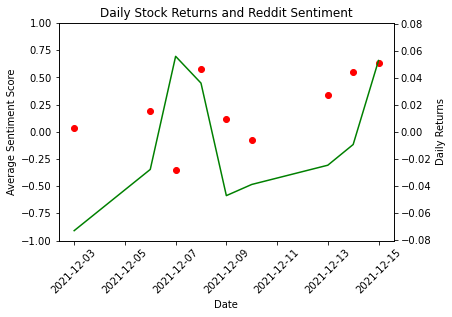

In [244]:
#Creating a plot of the average sentiment score for each day (red) along with
#the daily stock return (green)
fig,ax = plt.subplots()
plt.scatter(x = jdffiltered['DATE'], y = jdffiltered['score'], c = 'red')
ax.set_ylim(-1, 1)
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Average Sentiment Score')
ax2 = ax.twinx()
ax2.set_ylim(-max(abs(jdffiltered['DAILYRET'])) * 1.1, max(abs(jdffiltered['DAILYRET'])) * 1.1)
plt.plot(jdffiltered.set_index('DATE')['DAILYRET'], c = 'green')
ax2.set_ylabel('Daily Returns')
plt.title('Daily Stock Returns and Reddit Sentiment')

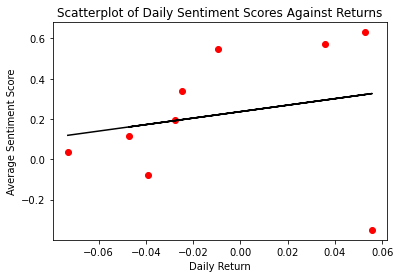

In [245]:
#Creating a scatterplot of sentiment scores against daily stock returns to see any
#potential correlation between them.
plt.scatter(x = jdffiltered['DAILYRET'], y = jdffiltered['score'], c = 'red')
plt.xlabel('Daily Return')
plt.ylabel('Average Sentiment Score')
plt.title('Scatterplot of Daily Sentiment Scores Against Returns')
try:
    lineM, lineB = np.polyfit(jdffiltered['DAILYRET'], jdffiltered['score'], 1)
    plt.plot(jdffiltered['DAILYRET'], lineM * jdffiltered['DAILYRET'] + lineB, c = 'black')
except:
    print('Best fit line could not be displayed.')

In [246]:
#Correlation between sentiment and daily stock returns.
jdffiltered.corr()['DAILYRET']['score']

0.22492850892068347